In [ ]:
!pip install py-ecg-detectors mpld3 heartpy hrv-analysis
!pip install keras-self-attention

In [ ]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.signal import *
import numpy as np
from ecgdetectors import Detectors
import tarfile
#from biosppy import storage
#from biosppy.signals import ecg
import mpld3
mpld3.enable_notebook()
import os
#import pywt
#import pywt.data
import matplotlib.patches as mpatches
import heartpy as hp
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values
import tensorflow as tf
import random
import shutil
import pandas as pd
from zipfile import ZipFile
from tensorflow.keras.layers import *
from keras.utils.vis_utils import plot_model
from sklearn.ensemble import RandomForestClassifier
from keras_self_attention import SeqSelfAttention
import csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
def extract_data():
  path = "/content/drive/MyDrive/signal_data/"
  with ZipFile(path+"X.zip",'r') as zip:
    zip.extractall()
  with ZipFile(path+"y.zip",'r') as zip:
    zip.extractall()
  with ZipFile(path+"labels.zip",'r') as zip:
    zip.extractall()
  with ZipFile(path+"Feature.zip",'r') as zip:
    zip.extractall()

In [ ]:
extract_data()

In [ ]:
print(len(os.listdir("/content/labels/")))
print(len(os.listdir("/content/X/")))
print(len(os.listdir("/content/y/")))
print(len(os.listdir("/content/Feature/")))

33362
33362
33362
33362


In [ ]:
def get_test_data():
  X=[]
  y=[]
  id=[]
  feat=[]
  
  x_list = os.listdir("/content/X_test/")
  random.shuffle(x_list)
  for xfile in x_list:
    X.append(np.load("/content/X_test/"+xfile))
    yfile = xfile[:-4]+"_label.npy"
    featfile = xfile[:-4]+"_feature.npy"
    y.append(np.load("/content/y_test/"+yfile))
    feat.append(np.load("/content/Feature_test/"+featfile))
    id.append(xfile[:-4])
  return np.array(X),np.array(feat),np.array(y),np.array(id)

In [ ]:
!mkdir Tests
!mkdir labels_done
!mkdir outputs

In [ ]:
def generator_2(batch_size):
  X_file_list = np.array(os.listdir("/content/X_train/"))
  random.shuffle(X_file_list)
  while True:
    X=[]
    y=[]
    feat=[]
    count=0
    steps = len(X_file_list)/batch_size
    splitted = np.array_split(X_file_list,steps)
    for ls in splitted:
      X=[]
      y=[]
      feat=[]
      for file_name in ls:
        X.append(np.load("/content/X_train/"+file_name))
        y_file_name = file_name[:-4]+"_label.npy"
        feat_file_name = file_name[:-4]+"_feature.npy"
        y.append(np.load("/content/y_train/"+y_file_name))
        feat.append(np.load("/content/Feature_train/"+feat_file_name))
      #print(np.array(X).shape)
      #print(np.array(y).shape)
      yield np.array(X),np.array(y)

    #for file_name in X_file_list:
    #  X.append(np.load("/content/X_train/"+file_name))
    #  y_file_name = file_name[:-4]+"_label.npy"
    #  feat_file_name = file_name[:-4]+"_feature.npy"
    #  y.append(np.load("/content/y_train/"+y_file_name))
    #  feat.append(np.load("/content/Feature_train/"+feat_file_name))
      #print(np.array(X)[None,...].shape)
      #print(np.array(y)[None,...].shape)
      #print(y)
      #yield [np.array(X)[None,...],np.array(feat)[None,...]],np.array(y)[None,...]

In [ ]:
def sep_train_test():
  !mkdir X_train
  !mkdir y_train
  !mkdir X_test
  !mkdir y_test
  !mkdir Feature_train
  !mkdir Feature_test
  ls = os.listdir("/content/X/")
  random.shuffle(ls)
  train = ls[:int(len(ls)*0.8)]
  test = ls[int(len(ls)*0.8):]
  for file_name in train:
    y_file_name = file_name[:-4]+"_label.npy"
    fea_file_name = file_name[:-4]+"_feature.npy"
    shutil.copyfile("/content/X/"+file_name,"/content/X_train/"+file_name)
    shutil.copyfile("/content/y/"+y_file_name,"/content/y_train/"+y_file_name)
    shutil.copyfile("/content/Feature/"+fea_file_name,"/content/Feature_train/"+fea_file_name)

  for file_name in test:
    y_file_name = file_name[:-4]+"_label.npy"
    fea_file_name = file_name[:-4]+"_feature.npy"
    shutil.copyfile("/content/X/"+file_name,"/content/X_test/"+file_name)
    shutil.copyfile("/content/y/"+y_file_name,"/content/y_test/"+y_file_name)
    shutil.copyfile("/content/Feature/"+fea_file_name,"/content/Feature_test/"+fea_file_name)

In [ ]:
print(len(os.listdir("Feature")))
print(len(os.listdir("X")))
print(len(os.listdir("y")))
print(len(os.listdir("labels")))

33362
33362
33362
33362


In [ ]:
!mkdir X_train
!mkdir y_train
!mkdir X_test
!mkdir y_test
!mkdir Feature_train
!mkdir Feature_test

In [ ]:
!rm -r X_train/*
!rm -r y_train/*
!rm -r X_test/*
!rm -r y_test/*
!rm -r Feature_train/*
!rm -r Feature_test/*

rm: cannot remove 'X_train/*': No such file or directory
rm: cannot remove 'y_train/*': No such file or directory
rm: cannot remove 'X_test/*': No such file or directory
rm: cannot remove 'y_test/*': No such file or directory
rm: cannot remove 'Feature_train/*': No such file or directory
rm: cannot remove 'Feature_test/*': No such file or directory


In [ ]:
sep_train_test()

mkdir: cannot create directory ‘X_train’: File exists
mkdir: cannot create directory ‘y_train’: File exists
mkdir: cannot create directory ‘X_test’: File exists
mkdir: cannot create directory ‘y_test’: File exists
mkdir: cannot create directory ‘Feature_train’: File exists
mkdir: cannot create directory ‘Feature_test’: File exists


In [ ]:
print(len(os.listdir("Feature_test/")))
print(len(os.listdir("Feature_train/")))
print(len(os.listdir("X_train/")))
print(len(os.listdir("X_test/")))
print(len(os.listdir("y_train/")))
print(len(os.listdir("y_test/")))

6673
26689
26689
6673
26689
6673


In [ ]:
inputs=0
outupts=0
x=0

In [ ]:
def res_block(filters,prev):
  x = Conv1D(filters,1)(prev)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  y = Conv1D(filters,1)(x)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)

  y = Conv1D(filters,1)(y)
  y = BatchNormalization()(y)

  z = add([x,y])
  z = LeakyReLU()(z)

  z = Dropout(0.2)(z)

  return z

In [ ]:
def mine():
  inputs = tf.keras.Input(shape=(12,5000,))
  feature_inputs = tf.keras.Input(shape=(13,))

  x = res_block(32,inputs)
  x = res_block(64,x)
  x = res_block(128,x)
  x = res_block(128,x)
  x = res_block(256,x)
  x = res_block(512,x)
  #print(x.shape)
  x = LSTM(512,return_sequences=True)(x)
  #print(x.shape)
  x = LSTM(512,return_sequences=True,return_state=True)(x)
  #print(x)
  x = Attention()(x)
  feature_x = Dense(13,activation="relu")(feature_inputs)
  #print(x.shape)
  x = Dense(256,activation="sigmoid")(x)
  x = Flatten()(x)
  x = Dense(32,activation="sigmoid")(x)
  combined = tf.keras.layers.concatenate([x,feature_x])
  y = Dense(27)(combined)

  outputs=Activation(activation="sigmoid")(y)
  return [inputs,feature_inputs], outputs

In [ ]:
def nn():
  inputs = tf.keras.Input(shape=(12,5000,))
  feature_inputs = tf.keras.Input(shape=(13,))

  x = res_block(32,inputs)
  x = res_block(64,x)
  x = res_block(128,x)
  x = res_block(128,x)
  x = res_block(256,x)
  x = res_block(512,x)
  #print(x.shape)
  x = LSTM(512,return_sequences=True)(x)
  #print(x.shape)
  x = LSTM(512,return_sequences=True,return_state=True)(x)
  #print(x)
  x = Attention()(x)
  #feature_x = Dense(13,activation="relu")(feature_inputs)
  #print(x.shape)
  #x = Dense(256,activation="sigmoid")(x)
  x = Dense(512)(x)
  x = Flatten()(x)
  #x = Dense(32,activation="sigmoid")(x)
  #combined = tf.keras.layers.concatenate([x,feature_x])
  x = Dense(27)(x)

  outputs=Activation(activation="sigmoid")(x)
  return inputs,outputs

In [ ]:
inputs, outputs = nn()
model = tf.keras.Model(inputs=inputs,outputs=outputs,name="resnet")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3,clipvalue=0.5,clipnorm=1.0), loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.BinaryCrossentropy()])

In [ ]:
model.summary()

In [ ]:
batch_size=1000
num_of_data=26689 #26689

In [ ]:
def produce_output(record_id,labels,outputs,threshold):
  ls = [
        270492004 , 
        164889003 , 
        164890007 ,
        426627000 , 
        713427006 , 
        713426002 , 
        445118002 ,
        39732003 ,
        164909002 ,
        251146004 , 
        698252002 ,
        10370003 ,
        284470004,
        427172004, 
        164947007 , 
        111975006 ,
        164917005 , 
        47665007 ,
        59118001 , 
        427393009 ,
        426177001,
        426783006 ,
        427084000 ,
        63593006 ,
        164934002 ,
        59931005 ,
        17338001]
  d = {}
  binary_outputs=[]
  scalar_outputs=[]
  for i in range(len(ls)):
    if outputs[i]>=threshold:#testing value: 0.5, 0.45, 0.4, 0.35, 0.3, 0.25
      binary_outputs.append(1)
      scalar_outputs.append(outputs[i])
      #d[ls[i]] = [1,outputs[i]]
    else:
      binary_outputs.append(0)
      scalar_outputs.append(outputs[i])
      #d[ls[i]] = [0,outputs[i]]
  with open("outputs/"+record_id+".csv","a") as myfile:
    wr = csv.writer(myfile)
    wr.writerows([ls,binary_outputs,scalar_outputs])
  #df = pd.DataFrame(d)
  #df.to_csv("outputs/"+record_id+".csv")

In [ ]:
def output(model):
  !rm -r labels_done/*
  !rm -r outputs/*
  X,feat,y,ids = get_test_data()
  results = model.predict(X)
  #print(results)
  for i in range(len(X)):
    produce_output(ids[i],y[i],results[i],0.5)
  for i in ids:
    shutil.copyfile("/content/labels/"+i+".hea","/content/labels_done/"+i+".hea")
  print(len(os.listdir("/content/labels_done")))
  print(len(os.listdir("/content/outputs")))
  
  !mkdir Tests/resnet_refine_100_512
  plot_model(model,to_file="Tests/resnet_refine_100_512/plot.png", show_shapes=True, show_layer_names=True)
  !python evaluate_model.py labels_done outputs Tests/resnet_refine_100_512/scores.csv Tests/resnet_refine_100_512/class_scores.csv
  model.save("Tests/resnet_refine_100_512/model")
  X=[]
  y=[]
  ids=[]

In [ ]:
callbacks = tf.keras.callbacks.ReduceLROnPlateau(monitor="binary_crossentropy",factor=0.5,patient=5,min_lr=1e-7)
!mkdir drive/MyDrive/signal_data/model_check_point
#model_check_point = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/signal_data/model_check_point/",monitor="brinary_crossentropy",save_freq="epoch")

mkdir: cannot create directory ‘drive/MyDrive/signal_data/model_check_point’: File exists


In [ ]:
history = model.fit_generator(generator=generator_2(batch_size),steps_per_epoch=num_of_data/batch_size, epochs=100,callbacks=[callbacks])
output(model)

In [ ]:
while True: pass

KeyboardInterrupt: ignored

In [ ]:
output(model)

6673
6673
Loading weights...
Loading label and output files...
Evaluating model...
- AUROC and AUPRC...
- Accuracy...
- F-measure...
- Challenge metric...
3391.472857142852
8263.306369047625
3734.8209821428673
-0.0758196385027303
Done.


INFO:tensorflow:Assets written to: Tests/resnet_refine_2_test/model/assets


INFO:tensorflow:Assets written to: Tests/resnet_refine_2_test/model/assets


In [ ]:
shutil.make_archive("labels_done","zip",".","labels_done")
shutil.make_archive("outputs","zip",".","outputs")

'/content/outputs.zip'

In [ ]:
from google.colab import files
files.download("outputs.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!mkdir /content/drive/MyDrive/signal_data/Tests_4

In [ ]:
from distutils.dir_util import copy_tree
copy_tree("Tests", "/content/drive/MyDrive/signal_data/Tests_4/")

['/content/drive/MyDrive/signal_data/Tests_4/resnet_refine_100_512123/model/variables/variables.data-00000-of-00001',
 '/content/drive/MyDrive/signal_data/Tests_4/resnet_refine_100_512123/model/variables/variables.index',
 '/content/drive/MyDrive/signal_data/Tests_4/resnet_refine_100_512123/model/saved_model.pb',
 '/content/drive/MyDrive/signal_data/Tests_4/resnet_refine_100_512123/plot.png',
 '/content/drive/MyDrive/signal_data/Tests_4/resnet_refine_100_512123/class_scores.csv',
 '/content/drive/MyDrive/signal_data/Tests_4/resnet_refine_100_512123/scores.csv']

In [ ]:
output(model)

In [ ]:
temp_labels = np.load("tttt/labels.npy")
temp_outputs = np.load("tttt/outputs.npy")

In [ ]:
print(temp_labels.shape)
print(temp_outputs.shape)

(6673, 24)
(6673, 24)


In [ ]:
temp_labels[0]

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [ ]:
for i in range(len(temp_outputs)):
  for j in range(len(temp_outputs[i])):
    if temp_outputs[i][j]:
      print(True)

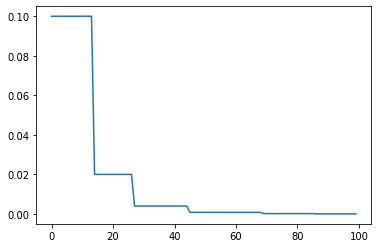

In [ ]:
plt.plot(history.history["lr"])

In [ ]:
tempX,tempF,tempy,tempid = get_test_data()

In [ ]:
import sklearn.metrics as skm
y_pred = model.predict(tempX)
y_pred = (y_pred>0.5)
y_true = tempy
cm = skm.multilabel_confusion_matrix(y_true,y_pred)
print(cm)
print(skm.classification_report(y_true,y_pred))

In [ ]:
cm.shape

(27, 2, 2)

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/signal_data/Tests_2/32_with_feature_05/model")


In [ ]:
model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.01>